In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser
from dynamic_env.env_config import EnvConfig


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome
from grid_world.graph import Graph
from grid_world.node import Node
from grid_world.tasks import *
from copy import deepcopy
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
def get_robot(genome, neat_config, env, genome_type):
    if genome.robot is not None:
        robot = genome.robot
    else:
        cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)
        design_substrate = morph_substrate(5, genome_type)
        design_net = create_phenotype_network(cppn, design_substrate)
        robot = generate_robot(design_net, 5)
        
    if not eval_robot_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)
    
    env = evogym.envs.gym.make(env, body=robot, connections=connections)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [9]:
with open(f"../island_cp/snk_3d_2/grid_gen_3000.pkl", "rb") as file:
    grid: Graph = pkl.load(file)
genome_type = grid.params.substrate_type
CustomGenome.robot_func = lambda self, net, config: generate_robot(net, grid.d_nodes["0"].sgr_pop.robot_size)
CustomGenome.substrate = morph_substrate(grid.d_nodes["0"].sgr_pop.robot_size, genome_type)
CustomGenome.robot_size = grid.d_nodes["0"].sgr_pop.robot_size
CustomGenome.spec_genotype_weight =  grid.params.spec_genotype_weight
CustomGenome.spec_phenotype_weight = grid.params.spec_phenotype_weight

FileNotFoundError: [Errno 2] No such file or directory: '../island_cp/snk_3d_2/grid_gen_3000.pkl'

 4097 9.37	 4097 9.37	 4097 9.37	 4097 9.37	 4097 9.37	 4097 9.37	
 4097 9.37	 3205 7.56	 3205 7.56	 3205 7.56	 3205 7.56	 4097 9.37	
 4097 9.37	 3205 7.56	 4097 9.37	 4097 9.37	 3205 7.56	 4097 9.37	
 4097 9.37	 3205 7.56	 4097 9.37	 4097 9.37	 3205 7.56	 4736 9.37	
 4097 9.37	 3205 7.56	 3205 7.56	 3205 7.56	 3205 7.56	 4097 9.37	
 4097 9.37	 4097 9.37	 4097 9.37	 4097 9.37	 4097 9.37	 4097 9.37	


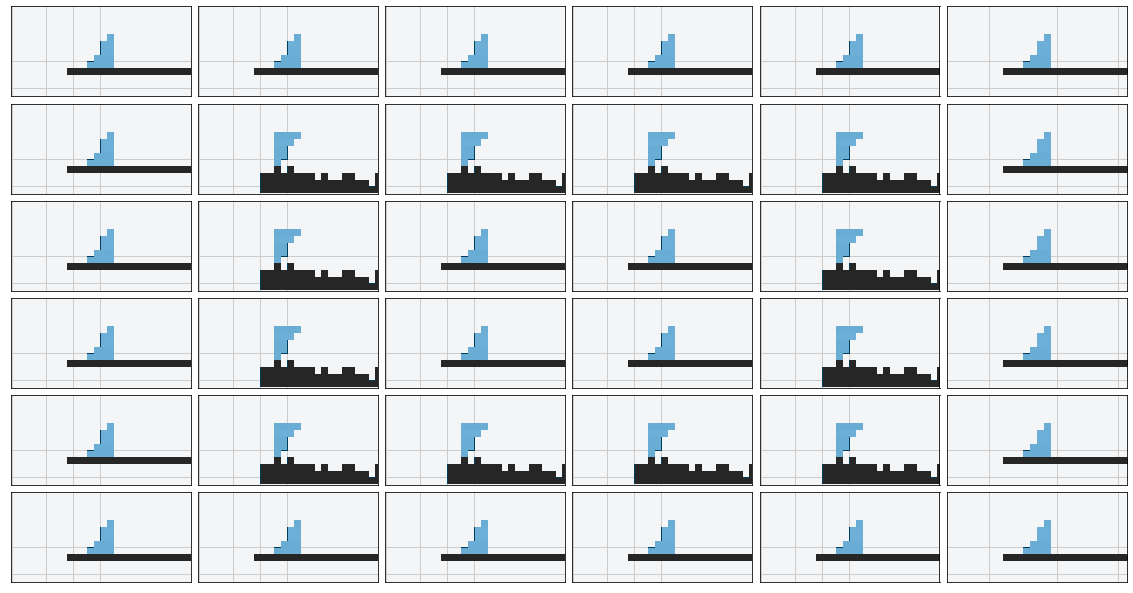

In [7]:
n_rows=6
n_cols=6

fig = plt.figure(1,(20,20))
grid_img = ImageGrid(fig, 111,
                 nrows_ncols=(n_rows,n_cols),
                 axes_pad=0.1,
                 share_all=True
                 )

grid_img[0].get_yaxis().set_ticks([])
grid_img[0].get_xaxis().set_ticks([])
cont = 0
for key, value in grid.d_nodes.items():
    best_genome = None
    best_genome_fit = -100000
    for g in value.sgr_pop.pop.population.values():
        # print(g.key, g.fitness)
        if g.fitness != None and g.fitness > best_genome_fit:
            best_genome = g
            best_genome_fit = g.fitness
    # best_genome = value.sgr_pop.best_genome
    fit = np.round(best_genome_fit, 2)
    task = {value.task}
    print(f" {best_genome.key} {fit}", end="\t")
    if cont%n_cols==n_cols-1:
        print()
    
    robot, img = get_robot(best_genome, value.sgr_pop.neat_config, value.task, genome_type) 
    if img is not None:
        # print(ag.robot)
        aux = Image.fromarray(img, 'RGB')
        # display(aux.resize((aux.size[0]//3, aux.size[1]//3)))
        grid_img[cont].imshow(aux,interpolation='none')
    cont += 1

In [10]:
for g in grid.d_nodes["29"].sgr_pop.pop.population.values():
    print(g.key, g.fitness)

1187 1.5592033481885692
1337 1.5452450224555219
2058 9.362372501957244
1508 4.4943523032653525
2063 None
2064 None


In [ ]:
grid.d_nodes["0"].sgr_pop.single_genome_fit(
    genome = grid.d_nodes["29"].sgr_pop.pop.population[2058],
    n_steps = 1000,
    env_name="ObstacleTraverser-v0",
    get_env_obs=None,
    dynamic_env_config=None,
    render=True, 
    save_gif=None,
)

In [7]:
grid.d_nodes["1"].sgr_pop.pop.population

{437: <sgr.body_speciation.CustomGenome at 0x7fbcbcc84390>,
 454: <sgr.body_speciation.CustomGenome at 0x7fbcbd6f47d0>,
 1177: <sgr.body_speciation.CustomGenome at 0x7fbcbcc080d0>,
 1178: <sgr.body_speciation.CustomGenome at 0x7fbcbcc08c10>,
 1179: <sgr.body_speciation.CustomGenome at 0x7fbcbcc18850>,
 1180: <sgr.body_speciation.CustomGenome at 0x7fbcbcc1f4d0>}

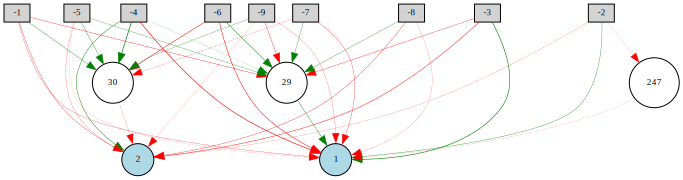

In [41]:
genome = grid.d_nodes["1"].sgr_pop.pop.population[12031]
cppn = neat.nn.FeedForwardNetwork.create(genome, grid.d_nodes["1"].sgr_pop.pop.config)
draw_net(cppn)